In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [12]:
# Load data
data_X = pd.read_csv('training_set_features.csv')
data_Y = pd.read_csv('training_set_labels.csv')

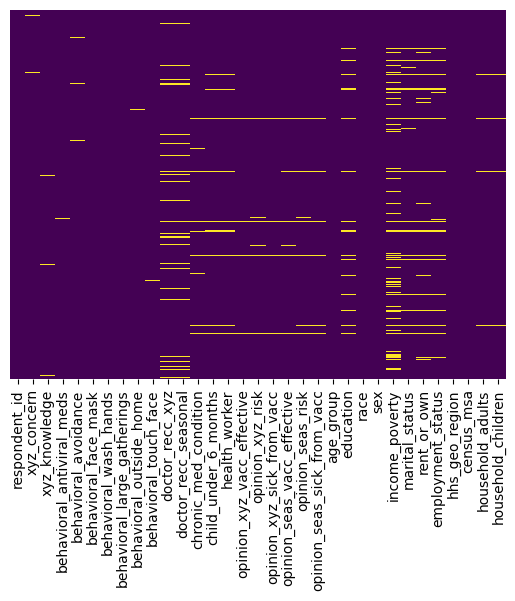

In [13]:
# Data preprocessing
data_X.isnull()
sns.heatmap(data_X.isnull(), yticklabels=False, cbar=False, cmap='viridis')

data_X = data_X.drop(['employment_occupation', 'employment_industry', 'health_insurance'], axis=1)
sns.heatmap(data_X.isnull(), yticklabels=False, cbar=False, cmap='viridis')

feature_cols = [col for col in data_X.columns]
cat_cols = [col for col in feature_cols if data_X[col].dtype == 'O']
cont_cols = [col for col in feature_cols if col not in cat_cols]

In [14]:
# Encoding categorical features
def encode_missing_columns(df, col):
    le = LabelEncoder()
    unique_without_nan = pd.Series([i for i in df[col].unique() if type(i) == str])
    le.fit(unique_without_nan)
    df[col] = df[col].apply(lambda x: le.transform([x])[0] if type(x) == str else x)

data_X_knn_imputer = data_X.copy()
for col in cat_cols:
    encode_missing_columns(data_X_knn_imputer, col)

       xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0              1.0            0.0                        0.0   
1              3.0            2.0                        0.0   
2              1.0            1.0                        0.0   
3              1.0            1.0                        0.0   
4              2.0            1.0                        0.0   
...            ...            ...                        ...   
26702          2.0            0.0                        0.0   
26703          1.0            2.0                        0.0   
26704          2.0            2.0                        0.0   
26705          1.0            1.0                        0.0   
26706          0.0            0.0                        0.0   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                       0.0                   0.0                    0.0   
1                       1.0                   0.0                    1.0   
2  

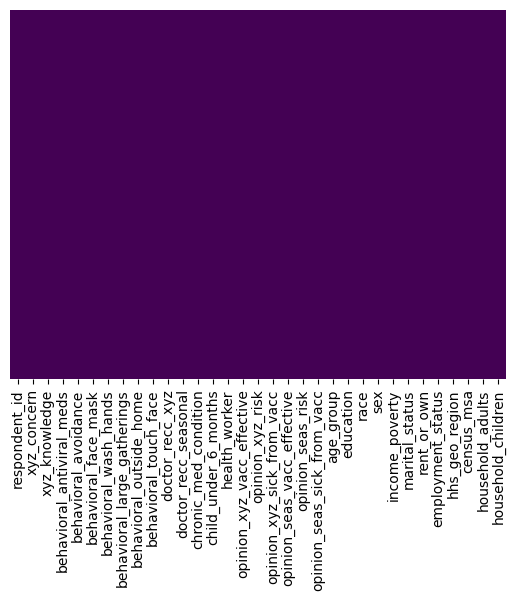

In [15]:
# Imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_X_knn_imputer[feature_cols] = knn_imputer.fit_transform(data_X_knn_imputer[feature_cols])
sns.heatmap(data_X_knn_imputer.isnull(), yticklabels=False, cbar=False, cmap='viridis')

train_data_X = data_X_knn_imputer.drop(['respondent_id'], axis=1)
print(train_data_X)
print(data_Y)

train_data_Y_xyz = data_Y.drop(['respondent_id', 'seasonal_vaccine'], axis=1)
train_data_Y_seasonal = data_Y.drop(['respondent_id', 'xyz_vaccine'], axis=1)

In [16]:
# Splitting and scaling data
X_train_xyz, X_test_xyz, y_train_xyz, y_test_xyz = train_test_split(train_data_X, train_data_Y_xyz, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_xyz = scaler.fit_transform(X_train_xyz)
X_test_xyz = scaler.transform(X_test_xyz)

In [22]:
# SVM model for xyz_vaccine
svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm.fit(X_train_xyz, y_train_xyz)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', probability=True, random_state=42)

In [23]:
# Evaluation
y_pred_svm = svm.predict_proba(X_test_xyz)[:, 1]
roc_auc_xyz = roc_auc_score(y_test_xyz, y_pred_svm)
print("SVM ROC AUC (XYZ):", roc_auc_xyz)

SVM ROC AUC (XYZ): 0.8166613666584892


In [25]:
# Repeat process for seasonal vaccine
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = train_test_split(train_data_X, train_data_Y_seasonal, test_size=0.3, random_state=42)
X_train_seasonal = scaler.fit_transform(X_train_seasonal)
X_test_seasonal = scaler.transform(X_test_seasonal)

svm2 = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm2.fit(X_train_seasonal, y_train_seasonal)

y_pred_svm2 = svm2.predict_proba(X_test_seasonal)[:, 1]
roc_auc_seasonal = roc_auc_score(y_test_seasonal, y_pred_svm2)
print("SVM ROC AUC (Seasonal):", roc_auc_seasonal)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM ROC AUC (Seasonal): 0.8478906654557532


In [27]:
# Processing final test set
data_X_final = pd.read_csv('test_set_features.csv')
data_X_knn_imputer = data_X_final.copy()
for col in cat_cols:
    encode_missing_columns(data_X_knn_imputer, col)

data_X_knn_imputer[feature_cols] = knn_imputer.fit_transform(data_X_knn_imputer[feature_cols])
data_X_final_cm = data_X_knn_imputer.drop(['respondent_id', 'employment_occupation', 'employment_industry', 'health_insurance'], axis=1)
data_X_final_scaled = scaler.transform(data_X_final_cm)

In [31]:
# Predicting final test set
y_pred_final_xyz = svm.predict_proba(data_X_final_scaled)[:, 1]
y_pred_final_seasonal = svm2.predict_proba(data_X_final_scaled)[:, 1]

respondent_id = np.arange(1, np.size(y_pred_final_xyz) + 1)
data = {'respondent_id': respondent_id, 'xyz_vaccine': y_pred_final_xyz, 'seasonal_vaccine': y_pred_final_seasonal}
df = pd.DataFrame(data)
df.to_csv('submission.csv', index=False)